In [4]:
from datasets import load_dataset, load_from_disk
import soundfile as sf
import os

# 1. Data preparation
### Download data of <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/en_us">English</a>, <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/ar_eg">Arabic</a>, and <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/de_de">German</a> languages from <a href="https://huggingface.co/datasets/google/fleurs">Fleurs</a> dataset and save them locally

In [2]:
if not os.path.exists("./data"): 
    data_folder_paths = ["ar_eg", "en_us", "de_de"]
    for data_folder in data_folder_paths:
        # Specify the path where you want to download the folder contents
        download_path = "./data/" + data_folder +"/"
        # Load the dataset
        dataset = load_dataset("google/fleurs", data_folder)
        dataset.save_to_disk(download_path)

### Load the downloaded datasets

In [5]:
eng_dataset = load_from_disk("./data/en_us/")
arb_dataset = load_from_disk("./data/ar_eg/")
ger_dataset = load_from_disk("./data/de_de/")

### Get some insights about the data

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
mode = "train"    # ===================================> change between train, test, validation and run the cell below
# Define bins for duration 
bins = range(0, 30, 2)  # Bin size of 2 seconds

# Initialize empty lists for duration
durations_eng = []
# Loop through each WAV file in your dataset
for sample in eng_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_eng.append(duration)

durations_df = pd.DataFrame({"Duration":durations_eng, "Language":"eng"})

durations_arb = []  
for sample in arb_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_arb.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_arb, "Language":"arb"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

durations_ger = []     
for sample in ger_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_ger.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_ger, "Language":"ger"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

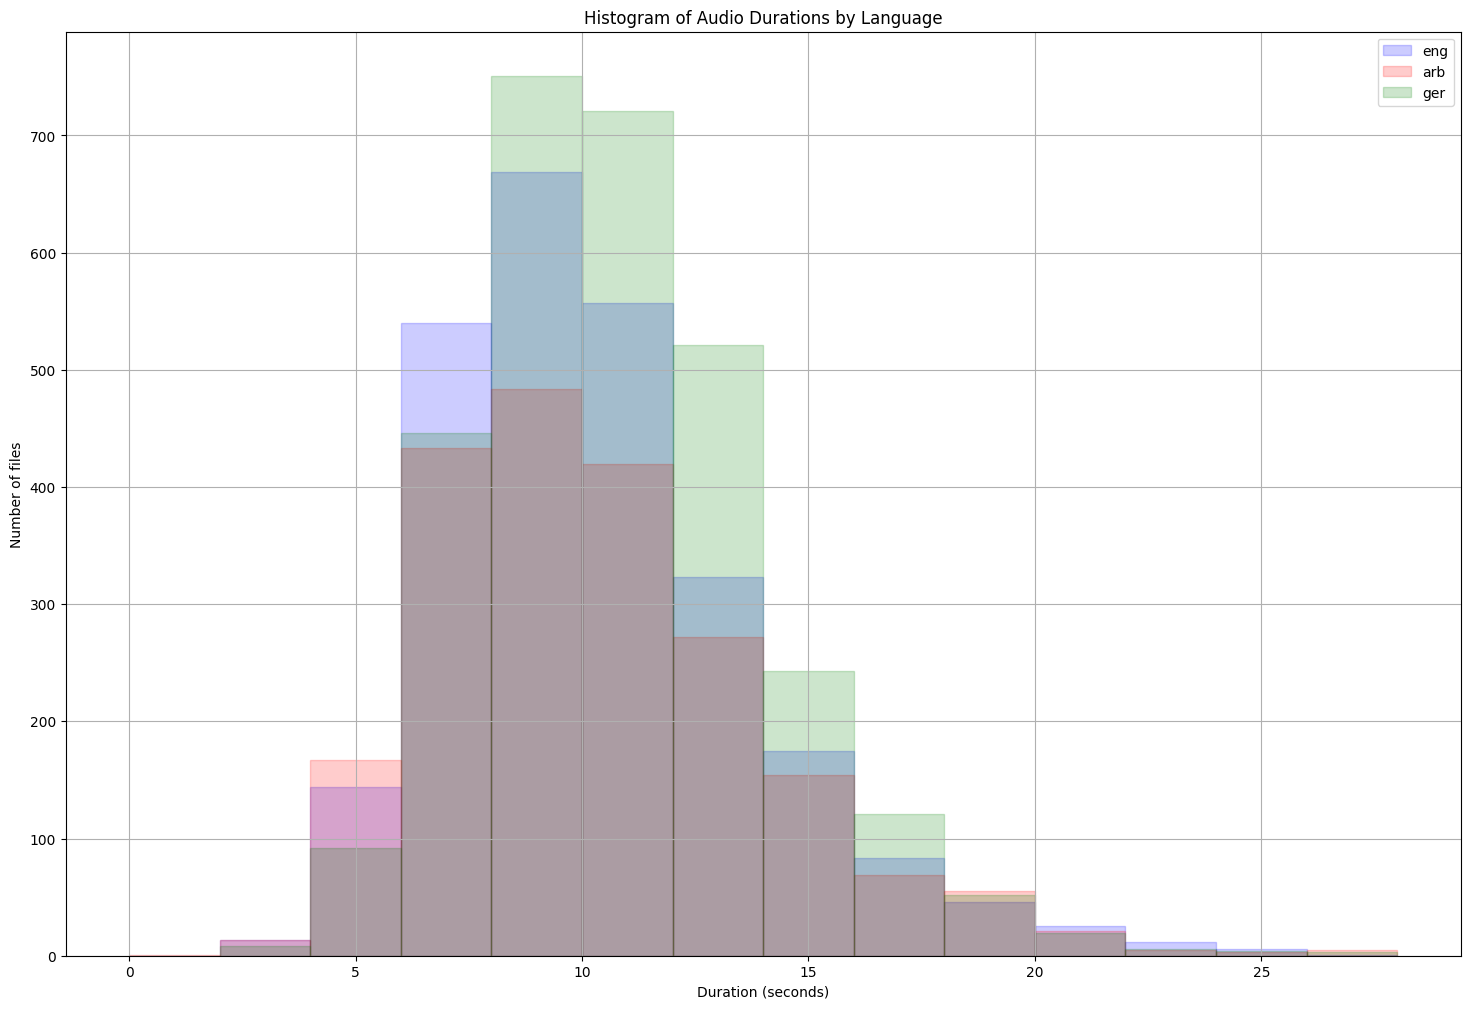

In [6]:
# Create the histogram plot
plt.figure(figsize=(18, 12))
plt.hist(durations_eng, bins, histtype='bar', color="blue", label="eng", alpha=0.2, edgecolor="blue")
plt.hist(durations_arb, bins, histtype='bar', color="red", label="arb", alpha=0.2, edgecolor="red")
plt.hist(durations_ger, bins, histtype='bar', color="green", label="ger", alpha=0.2, edgecolor="green")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.title("Histogram of Audio Durations by Language")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
durations_df.describe()

,Duration
count,7693.000000
mean,10.548216
std,3.532879
min,0.319063
25%,8.100000
50%,10.080000
75%,12.480000
max,42.360000


Remark:
- most of the data in the training set is concentrated at recordings in the range 6-14 seconds recording size
- the same could be said for testing except that of german language it is spread more towards longer recordings
- the validation is centralized in the range 6-12
- from the above description of the training dataset the mean duration is 10.5 and the std is 3.5 so if we take our range [6-14] we will have covered nearly 68% of the population with maintaining a reasonable recording size range

Conclusion:
- we will filter the dataset and take only recordings of durations in range 6-14 seconds

### Apply the filteration

In [8]:
MIN_RECORDING_SIZE = 6
MAX_RECORDING_SIZE = 14

In [9]:
eng_indices =[]
for index, sample in enumerate(eng_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        eng_indices.append(index)
        
arb_indices =[]
for index, sample in enumerate(arb_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        arb_indices.append(index)
        
ger_indices =[]
for index, sample in enumerate(ger_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        ger_indices.append(index)
        
print("English count: ",len(eng_indices), "\tArabic count: ", len(arb_indices), "\tGerman count: ", len(ger_indices))

English count:  2076 	Arabic count:  1587 	German count:  2431


# 1. HMM

In [6]:
import librosa
from hmmlearn import hmm
import numpy as np

### 1. get mel spectrogram

In [33]:
mfccs = {}  # Store extracted MFCCs
lengths = {}

mfccs_eng = []
for index in eng_indices:
  mfcc = librosa.feature.mfcc(y=eng_dataset["train"][index]["audio"]["array"], sr=eng_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_eng.append(mfcc)
mfccs["eng"] = np.vstack(mfccs_eng)

mfccs_arb = []
for index in arb_indices:
  mfcc = librosa.feature.mfcc(y=arb_dataset["train"][index]["audio"]["array"], sr=arb_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_arb.append(mfcc)
mfccs["arb"] = np.vstack(mfccs_arb)

mfccs_ger = []
for index in ger_indices:
  mfcc = librosa.feature.mfcc(y=ger_dataset["train"][index]["audio"]["array"], sr=ger_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_ger.append(mfcc)
mfccs["ger"]= np.vstack(mfccs_ger)

### 2. Train the  <a href="https://hmmlearn.readthedocs.io/en/latest/api.html#gmmhmm">HMMs</a>

In [53]:
num_iterations = 50
num_states = 10

In [54]:
models ={}
for language, mfccs_list in mfccs.items():
    # Train a model per language
    model = hmm.GMMHMM(n_components=num_states, n_iter=num_iterations, verbose=True)
    model.fit(mfccs[language])
    # Add the model to the dictionary
    models[language] = model

         1 -52133258.70357017             +nan
         2 -50761515.65906516 +1371743.04450501
         3 -50225328.90149743 +536186.75756773
         4 -49879496.96970239 +345831.93179504
         5 -49665282.70706006 +214214.26264233
         6 -49574795.14748824  +90487.55957182
         7 -49515623.11014266  +59172.03734558
         8 -49409911.26133940 +105711.84880326
         9 -49329711.35584515  +80199.90549424
        10 -49301074.37412380  +28636.98172136
        11 -49286590.77376999  +14483.60035381
        12 -49275704.57575964  +10886.19801035
        13 -49268879.14714210   +6825.42861754
        14 -49264597.36365582   +4281.78348628
        15 -49260982.24403188   +3615.11962394
        16 -49257277.27351695   +3704.97051493
        17 -49253108.80283720   +4168.47067975
        18 -49248164.85113017   +4943.95170703
        19 -49241432.29692384   +6732.55420633
        20 -49229855.97643199  +11576.32049185
        21 -49210044.02739750  +19811.94903449
        22 -

#### Save the trained models

In [55]:
import pickle
import os

In [58]:
# Create the directory if it doesn't exist
if not os.path.exists("./models"):
    os.makedirs("./models")
for language, model in models.items():
    with open("./models/"+language+".pkl", "wb") as file:
        pickle.dump(model, file)

#### Load the saved trained models

In [59]:
models2 = {}
for file_name in os.listdir("./models/"):
    if file_name.endswith(".pkl"):
        full_path = os.path.join("./models/", file_name)
        with open(full_path, "rb") as file:
            models2[file_name.split(".")[0]] = pickle.load(file)
print(models2)

{'arb': GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5...
       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
       n_components=10, n_iter=50, verbose=True,
       weights_prior=

### 3. Test the HMMs

In [60]:
eng_test_indices =[]
for index, sample in enumerate(eng_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        eng_test_indices.append(index)
        
arb_test_indices =[]
for index, sample in enumerate(arb_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        arb_test_indices.append(index)
        
ger_test_indices =[]
for index, sample in enumerate(ger_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        ger_test_indices.append(index)
        
print("English test count: ",len(eng_indices), "\tArabic test count: ", len(arb_indices), "\tGerman test count: ", len(ger_indices))

English test count:  2076 	Arabic test count:  1587 	German test count:  2431


In [61]:
label2number = {"eng":0,
                "arb":1,
                "ger":2}

In [62]:
def get_prediction(features, models_dictionary):
    scoreList = {}
    for model_label, model in models_dictionary.items():
        score = model.score(features)
        scoreList[model_label] = score
    predict = max(scoreList, key=scoreList.get)
    return label2number[predict]

In [63]:
true_labels = []
predicted_labels = []
# iterate through the test data and get the prediction and the true label
for index in eng_test_indices:
    mfcc = librosa.feature.mfcc(y=eng_dataset["test"][index]["audio"]["array"], sr=eng_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(0)
    predicted_labels.append(get_prediction(mfcc, models))
    
for index in arb_test_indices:
    mfcc = librosa.feature.mfcc(y=arb_dataset["test"][index]["audio"]["array"], sr=arb_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(1)
    predicted_labels.append(get_prediction(mfcc, models))
    
for index in ger_test_indices:
    mfcc = librosa.feature.mfcc(y=ger_dataset["test"][index]["audio"]["array"], sr=ger_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(2)
    predicted_labels.append(get_prediction(mfcc, models))

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [68]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy*100:.2f}%" )

Accuracy: 34.44%


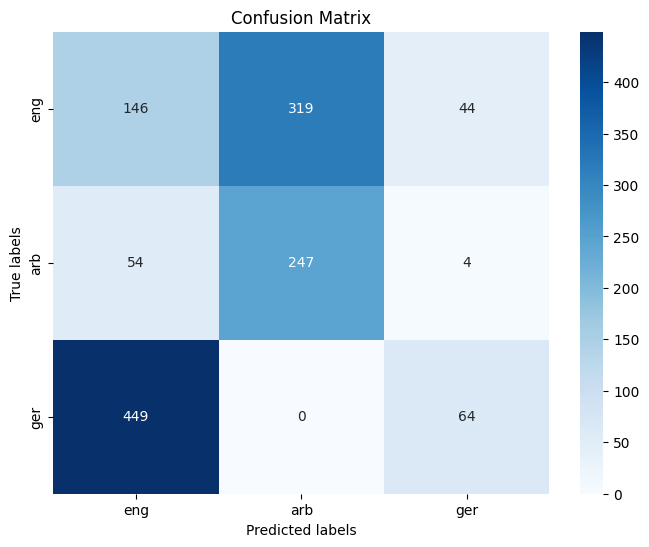

In [66]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['eng', 'arb', 'ger'], yticklabels=['eng', 'arb', 'ger'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

___
___
___
# Data prep for DL
before we proceed with LSTM we will create all the mfccs and store them so that we could load them directly rather than computing them each time

In [25]:
# create files if they dont exists
if not os.path.exists("./mfccs"):
    for lang in ["eng", "arb","ger"]:
        os.makedirs("./mfccs/train/"+lang)
        os.makedirs("./mfccs/test/"+lang)
        os.makedirs("./mfccs/validation/"+lang)

In [26]:
dataset_lang = {"eng": eng_dataset,
                "arb": arb_dataset,
                "ger": ger_dataset}
max_length = 0
#outter loop per dataset 
for mode in ["train", "test","validation"]:
    path = "./mfccs/"+mode+"/"
    #inner loop per language
    for language in ["eng", "arb", "ger"]:
        path = "./mfccs/"+mode+"/"+language+"/"
        dataset_lang[language][mode]
        for index, sample in enumerate(dataset_lang[language][mode]):
            mf = librosa.feature.mfcc(y=sample["audio"]["array"], sr=sample["audio"]["sampling_rate"]).T
            filename = os.path.join(path, f"{index}.npy")
            np.save(filename, mf)
            if mf.shape[0] > max_length:
                max_length = mf.shape[0]

In [27]:
print(max_length)

1499


The max sequence length is 1499. we will use this as the input size and pad any smaller mfcc

___
___
___
# 2. LSTM
change the environment to the one with pytorch installed on

In [2]:
import os
from datasets import load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader

In [4]:
def get_files_count(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

### 1. Define a dataset class

In [26]:
class CustomDataset(Dataset):
    def __init__(self, path_to_mode, tensor_shape = (1499,20)):
        self.path_to_eng = path_to_mode + "/eng/"
        self.path_to_arb = path_to_mode + "/arb/" 
        self.path_to_ger = path_to_mode + "/ger/" 
        
        self.eng_files_count = get_files_count(self.path_to_eng)
        self.arb_files_count = get_files_count(self.path_to_arb)
        self.ger_files_count = get_files_count(self.path_to_ger)
        self.tensor_shape = tensor_shape
           
    def __len__(self):
        return self.eng_files_count + self.arb_files_count + self.ger_files_count

    def __getitem__(self, idx):
        if idx < self.eng_files_count:
            file_index = idx
            # Specify the filename
            filename = self.path_to_eng + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 0
        elif (idx > self.eng_files_count) and (idx < (self.eng_files_count+self.arb_files_count)):
            file_index = idx - self.eng_files_count
            # Specify the filename
            filename = self.path_to_arb + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 1
        elif (idx > (self.eng_files_count+self.arb_files_count)) and (idx < (self.eng_files_count+self.arb_files_count+self.ger_files_count)):
            file_index = idx - (self.eng_files_count+self.arb_files_count)
            # Specify the filename
            filename = self.path_to_ger + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 2
        else:
             raise IndexError(f"Index {idx} is out of range for array of length {self.__len__()}")
         
        # Pad the array with zeros to match the predefined shape
        padded_array = np.pad(mfcc, [(0, self.tensor_shape[0] - mfcc.shape[0]), 
                                     (0, self.tensor_shape[1] - mfcc.shape[1])], 
                      mode='constant')
        # Convert the padded array to a PyTorch tensor
        tensor_from_array = torch.tensor(padded_array)
        
        return tensor_from_array, label

In [27]:
batch_size = 200
shuffle = True
desired_shape = (1499, 20)

In [33]:
train_dataset = CustomDataset("./mfccs/train", desired_shape)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

val_dataset = CustomDataset("./mfccs/validation", desired_shape)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

test_dataset = CustomDataset("./mfccs/test", desired_shape)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

#define a dictionary with the dataloaders
dataloaders ={"train":train_loader,
              "val":val_loader,
              "test":test_loader}

# Create an iterator from the DataLoader
train_iter = iter(dataloaders["train"])
# Get a batch of images without advancing the count
batch_mfccs, batch_labels = next(train_iter)
# Perform operations with the batch of images
print("Batch size: ", batch_mfccs.size(), "\nLables vector size: ", batch_labels.size())

Batch size:  torch.Size([200, 1499, 20]) 
Lables vector size:  torch.Size([200])


### 2. Define the network architecture

___
___
___
### Miscellaneous

In [5]:
print(eng_dataset)
eng_dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2602
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 394
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 647
    })
})


{'id': 903,
 'num_samples': 108800,
 'path': 'C:\\Users\\zakar\\.cache\\huggingface\\datasets\\downloads\\extracted\\5b79e165dbdf7afbe10dfbf7bd7a0d24b09808979e2d851509a2d6e2e7983641\\10004088536354799741.wav',
 'audio': {'path': '10004088536354799741.wav',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.15904617e-06, -3.03983688e-06, -3.27825546e-06]),
  'sampling_rate': 16000},
 'transcription': 'a tornado is a spinning column of very low-pressure air which sucks the surrounding air inward and upward',
 'raw_transcription': 'A tornado is a spinning column of very low-pressure air, which sucks the surrounding air inward and upward.',
 'gender': 1,
 'lang_id': 19,
 'language': 'English',
 'lang_group_id': 0}

In [24]:

def generate_wav(path, file_name, audio_data, sampling_rate):
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the audio data as a WAV file
    sf.write(path+file_name, audio_data, sampling_rate)


In [25]:
generate_wav("./eng/","eng1.wav", eng_dataset["train"][0]["audio"]["array"], eng_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./ger/","ger1.wav", ger_dataset["train"][0]["audio"]["array"], ger_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./arb/","arb1.wav", arb_dataset["train"][0]["audio"]["array"], arb_dataset["train"][0]["audio"]["sampling_rate"])
